In [ ]:
!pip install halo pyarrow numerapi lightgbm tabulate optuna

import os
from halo import Halo
import json
import gc
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import numerapi
import lightgbm
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from utils import (
    save_model,
    load_model,
    neutralize,
    get_biggest_change_features,
    get_time_series_cross_val_splits,
    validation_metrics,
    ERA_COL,
    DATA_TYPE_COL,
    TARGET_COL,
    EXAMPLE_PREDS_COL
)

from metrics import evaluate

from numerapi import NumerAPI
napi = NumerAPI()

current_round = napi.get_current_round(tournament=8)  # tournament 8 is the primary Numerai Tournament

# Tournament data changes every week so we specify the round in their name. Training
# and validation data only change periodically, so no need to download them every time.
print('Downloading dataset files...')
napi.download_dataset("numerai_training_data_int8.parquet", "training_data_int8.parquet")
# napi.download_dataset("numerai_tournament_data_int8.parquet", f"tournament_data_int8_{current_round}.parquet")
# napi.download_dataset("numerai_validation_data_int8.parquet", f"validation_data_int8.parquet")
# napi.download_dataset("example_validation_predictions.parquet", "example_validation_predictions.parquet")
napi.download_dataset("features.json", "features.json")

with open("features.json", "r") as f:
    feature_metadata = json.load(f)

features_small = set(feature_metadata["feature_sets"]["small"])
features_medium = set(feature_metadata["feature_sets"]["medium"])

in_medium_not_in_small = features_medium - features_small
features = list(features_small) + list(in_medium_not_in_small)

train_pq_path = "training_data_int8.parquet"

# read in just those features along with era and target columns
read_columns = features + [ERA_COL, DATA_TYPE_COL, TARGET_COL]
df_train = pd.read_parquet(train_pq_path, columns=read_columns)

eras = df_train.era.astype(int)
df_train["era"] = eras

training_data = df_train
gc.collect()

In [ ]:
eras = df_train["era"]

In [ ]:
# creates era groups 
era_groups_50 = (eras // 50)
era_groups_50

id
n003bba8a98662e4     0
n003bee128c2fcfc     0
n0048ac83aff7194     0
n00691bec80d3e02     0
n00b8720a2fdc4f2     0
                    ..
nffcc1dbdf2212e6    11
nffd71b7f6a128df    11
nffde3b371d67394    11
nfff1a1111b35e84    11
nfff2bd38e397265    11
Name: era, Length: 2412105, dtype: int64

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
results50 = []
for train_era, tdf in training_data.groupby(era_groups_50):
    print(train_era)
    model = LinearRegression()
    model.fit(tdf[features], tdf[TARGET_COL])
    for test_era, tdf in training_data.groupby(era_groups_50):
        results50.append([
            train_era,
            test_era,
            np.corrcoef(tdf[TARGET_COL], model.predict(tdf[features]))[0][1]
        ])

0
1
2
3
4
5
6
7
8
9
10
11


In [ ]:
for result in results50:
    result[2] = result[2][0][1]

In [ ]:
results_df = pd.DataFrame(
    results50,
    columns=["train_era", "test_era", "score"]
).pivot(index="train_era", columns="test_era", values="score")
results_df

test_era,0,1,2,3,4,5,6,7,8,9,10,11
train_era,,,,,,,,,,,,
0,0.142712,0.001675,-0.004287,-0.000451,0.000811,0.002499,-0.003731,-0.000972,-0.005259,-0.004380,-0.002052,0.004319
1,0.064007,0.122238,0.042833,0.042819,0.030373,0.012702,0.031961,0.036156,0.033025,0.034990,0.033364,0.031643
2,0.057595,0.050565,0.112635,0.051713,0.037496,0.009663,0.027165,0.029809,0.034304,0.027929,0.025737,0.022360
3,0.045954,0.045773,0.051466,0.112320,0.040868,0.012318,0.041645,0.043169,0.033802,0.027210,0.028978,0.024780
4,0.038798,0.034977,0.039421,0.042512,0.114829,0.016534,0.028671,0.030487,0.040408,0.027490,0.036682,0.035221
5,0.019065,0.022110,0.016954,0.020297,0.026184,0.103316,0.027412,0.011212,0.017619,0.008269,0.018062,0.005953
6,0.047452,0.032947,0.030161,0.039872,0.026866,0.019422,0.124678,0.032825,0.025474,0.020323,0.029619,0.016679
7,0.047507,0.042196,0.030493,0.043417,0.031630,0.010995,0.041966,0.105952,0.040634,0.026151,0.024771,0.018963
8,0.044550,0.035360,0.034865,0.035920,0.039819,0.012835,0.026501,0.033309,0.112102,0.032537,0.027758,0.028048


In [ ]:
param_grid = {
    'n_estimators': 100, 
    'learning_rate': 0.01, 
    'num_leaves': 25, 
    'max_depth': 6, 
    'colsample_bytree': 0.1,
    "max_bin": 50,
}

In [ ]:
results50_lgb = []
for train_era, tdf in training_data.groupby(era_groups_50):
    print(train_era)
    model = lightgbm.LGBMRegressor(**param_grid)
    model.fit(tdf[features], tdf[TARGET_COL])
    for test_era, tdf in training_data.groupby(era_groups_50):
        results50_lgb.append([
            train_era,
            test_era,
            np.corrcoef(tdf[TARGET_COL], model.predict(tdf[features]))[0][1]
        ])

0
1
2
3
4
5
6
7
8
9
10
11


In [ ]:
results_df_lgb = pd.DataFrame(
    results50_lgb,
    columns=["train_era", "test_era", "score"]
).pivot(index="train_era", columns="test_era", values="score")
results_df_lgb

test_era,0,1,2,3,4,5,6,7,8,9,10,11
train_era,,,,,,,,,,,,
0,0.247222,0.057658,0.050392,0.056437,0.042267,0.016893,0.045339,0.038797,0.042321,0.027754,0.036427,0.025591
1,0.077309,0.230865,0.055236,0.052595,0.042839,0.021200,0.048046,0.048773,0.045136,0.035378,0.037461,0.033913
2,0.066081,0.056908,0.221121,0.060932,0.056890,0.018741,0.047345,0.044011,0.048194,0.032832,0.040893,0.034044
3,0.067238,0.057585,0.060827,0.213078,0.051110,0.018870,0.049257,0.042705,0.042293,0.034479,0.042328,0.027590
4,0.061535,0.049327,0.056477,0.057085,0.206905,0.025080,0.037594,0.042903,0.047450,0.025076,0.047345,0.037822
5,0.017545,0.024345,0.019552,0.020445,0.028568,0.202864,0.027865,0.019878,0.019914,0.012781,0.017049,0.009896
6,0.057439,0.049720,0.042004,0.043396,0.035104,0.023715,0.222191,0.040899,0.035219,0.032435,0.035809,0.018994
7,0.057052,0.051996,0.042600,0.045804,0.045749,0.023952,0.043213,0.213772,0.051078,0.034280,0.034456,0.032923
8,0.053728,0.048513,0.046197,0.044854,0.048526,0.016464,0.036220,0.047124,0.210684,0.041393,0.038536,0.035788


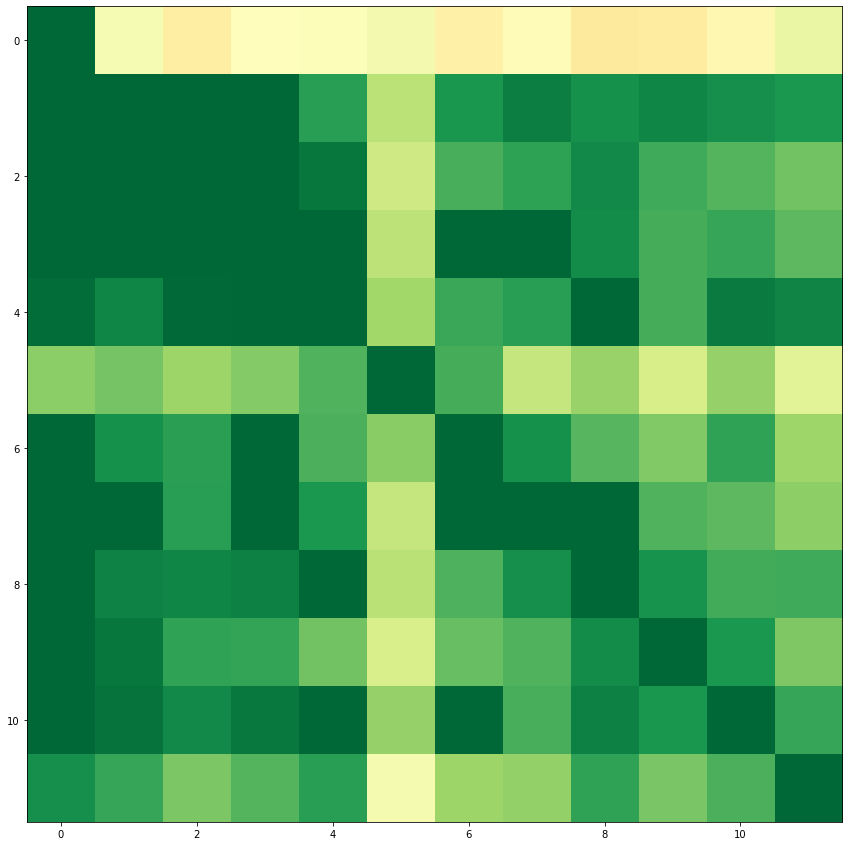

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
plt.imshow(results_df, vmin=-0.04, vmax=0.04, cmap="RdYlGn")

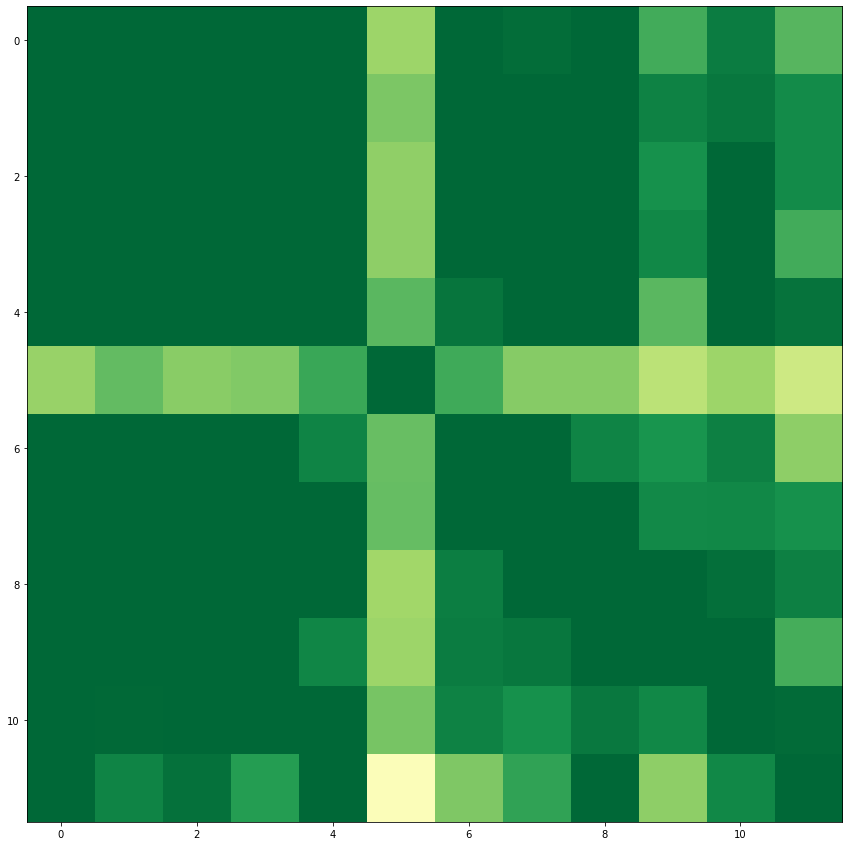

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(results_df_lgb, vmin=-0.04, vmax=0.04, cmap="RdYlGn")

## Observations
 I see that for the linear model, the eras in group 0 (1-50) have little predictive power on any other group \
 So, there might not be any linear relationship between group 0 and the others \
 On both plots, era group 5 (250-300) does not generalize well when trained on, and is hard to predict by any other group

In [ ]:
eras = eras[eras.isin(np.arange(1, 575, 4))]
eras_sub = (eras-1)//4

In [ ]:
# creates era groups 
era_groups_15 = (eras_sub // 15)
era_groups_15.value_counts()

4    71000
7    69251
8    67610
3    67268
6    66300
5    61933
2    61333
1    54214
0    42920
9    42282
Name: era, dtype: int64

In [ ]:
results15_linear = []
for train_era, tdf in training_data.groupby(era_groups_15):
    print(train_era)
    model = LinearRegression()
    model.fit(tdf[features], tdf[TARGET_COL])
    for test_era, tdf in training_data.groupby(era_groups_15):
        results15_linear.append([
            train_era,
            test_era,
            np.corrcoef(tdf[TARGET_COL], model.predict(tdf[features]))[0][1]
        ])

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


In [ ]:
results_df = pd.DataFrame(
    results15_linear,
    columns=["train_era", "test_era", "score"]
).pivot(index="train_era", columns="test_era", values="score")
results_df

test_era,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
train_era,,,,,,,,,,
0.0,0.143808,-0.000806,0.000824,0.000188,-0.001430,0.002252,-0.000944,0.004368,-0.002137,-0.001903
1.0,0.060162,0.121323,0.039606,0.034177,0.018525,0.028195,0.032495,0.031023,0.036293,0.023989
2.0,0.049540,0.042736,0.114000,0.044505,0.013907,0.039354,0.036806,0.020589,0.027494,0.027639
3.0,0.037899,0.038112,0.045665,0.110567,0.022557,0.030157,0.042965,0.024353,0.036091,0.025125
4.0,0.020030,0.022599,0.018177,0.028908,0.107088,0.024231,0.016406,0.015862,0.016945,0.019393
5.0,0.045415,0.029621,0.039375,0.027686,0.019383,0.124721,0.033950,0.024111,0.024237,0.020672
6.0,0.057582,0.035927,0.035248,0.041284,0.014665,0.039535,0.111763,0.035009,0.030193,0.018332
7.0,0.034167,0.033193,0.022555,0.023080,0.014727,0.025765,0.034714,0.102627,0.036306,0.020604
8.0,0.047096,0.043263,0.029539,0.036681,0.015168,0.031664,0.034829,0.038023,0.105180,0.028596


In [ ]:
param_grid = {
    'n_estimators': 50, 
    'learning_rate': 0.01, 
    'num_leaves': 25, 
    'max_depth': 6, 
    'colsample_bytree': 0.1,
    "max_bin": 50,
}

In [ ]:
results15_lgb = []
for train_era, tdf in training_data.groupby(era_groups_15):
    print(train_era)
    model = lightgbm.LGBMRegressor(**param_grid)
    model.fit(tdf[features], tdf[TARGET_COL])
    for test_era, tdf in training_data.groupby(era_groups_15):
        results15_lgb.append([
            train_era,
            test_era,
            np.corrcoef(tdf[TARGET_COL], model.predict(tdf[features]))[0][1]
        ])

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


In [ ]:
results_df_lgb_15 = pd.DataFrame(
    results15_lgb,
    columns=["train_era", "test_era", "score"]
).pivot(index="train_era", columns="test_era", values="score")
results_df_lgb_15

test_era,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
train_era,,,,,,,,,,
0.0,0.251231,0.047975,0.054918,0.046599,0.022815,0.049804,0.048839,0.026217,0.029477,0.029671
1.0,0.060887,0.238206,0.042640,0.041455,0.024390,0.040031,0.037074,0.032583,0.035300,0.029399
2.0,0.057852,0.039503,0.209174,0.049845,0.016782,0.041633,0.046184,0.030043,0.037460,0.033892
3.0,0.056256,0.048074,0.052817,0.218505,0.023944,0.044742,0.046649,0.023708,0.037166,0.031287
4.0,0.024793,0.026840,0.025077,0.027117,0.206046,0.020896,0.027900,0.021942,0.023489,0.020160
5.0,0.057634,0.043895,0.036645,0.042045,0.018775,0.232342,0.045553,0.030033,0.031503,0.023372
6.0,0.064786,0.050004,0.047546,0.049746,0.026886,0.048500,0.217203,0.047102,0.038089,0.035920
7.0,0.045510,0.038777,0.037613,0.033623,0.024412,0.037812,0.056646,0.231976,0.035369,0.034393
8.0,0.041621,0.038479,0.035298,0.042339,0.021756,0.036776,0.041690,0.032927,0.214813,0.030360


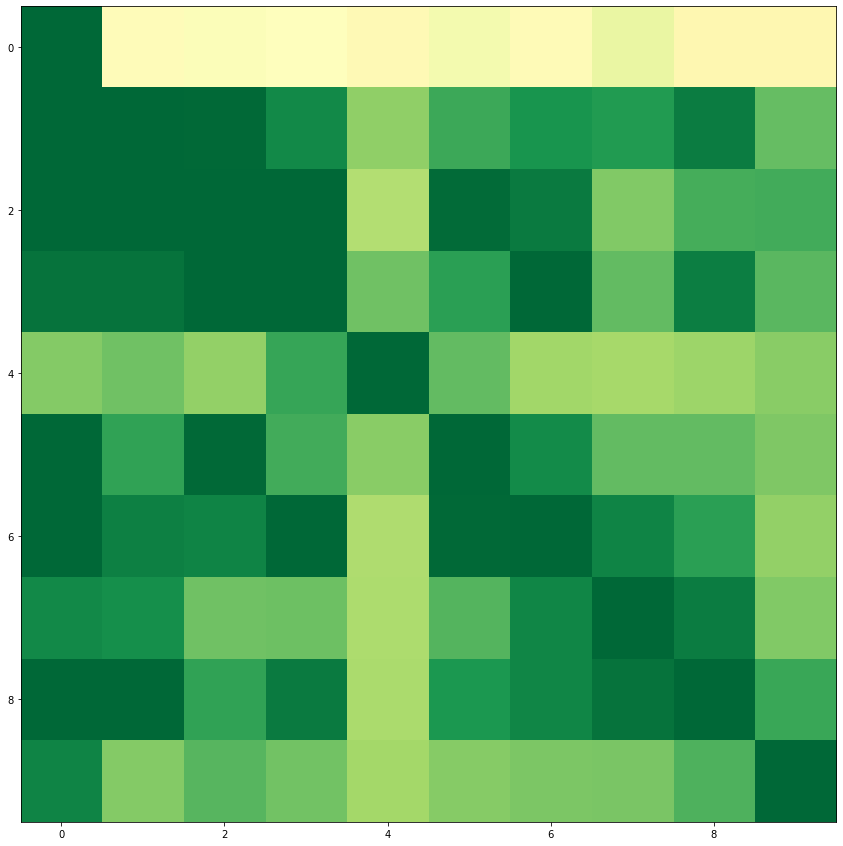

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
plt.imshow(results_df, vmin=-0.04, vmax=0.04, cmap="RdYlGn")

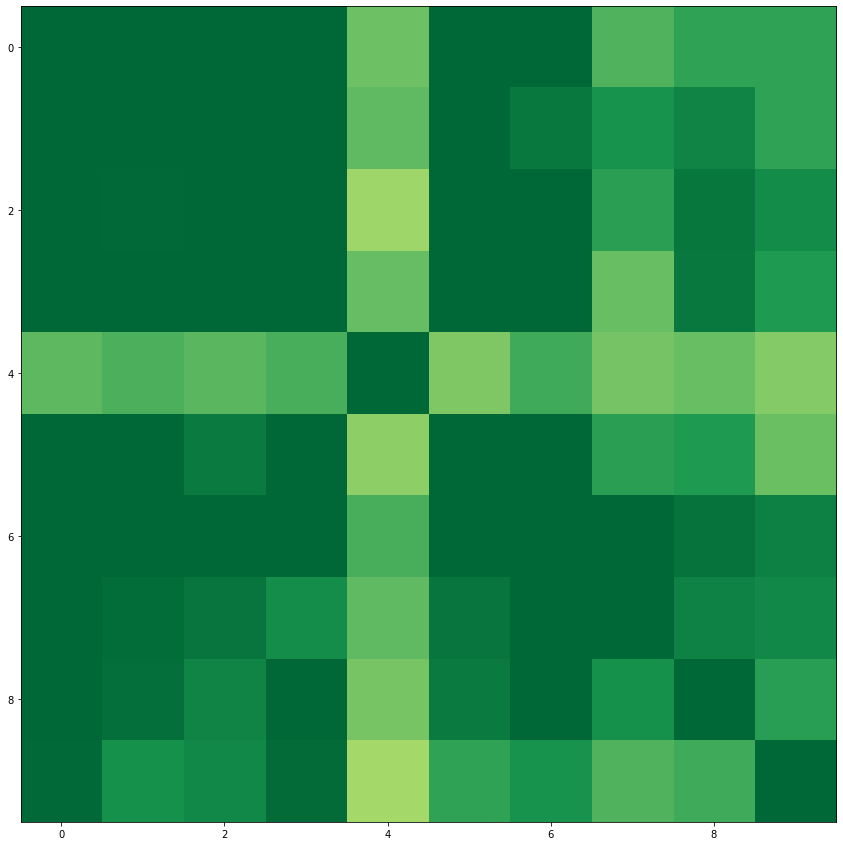

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(results_df_lgb_15, vmin=-0.04, vmax=0.04, cmap="RdYlGn")

## Observations
Again, the linear model does very badly when trained on group 0 (which is every 4th era from 1-60) \
when trained on group 9 (every 4th era from 540-574) it also does badly, but this might be due to little training data \

# Idea
Train a linear model Not on group 0, on groups 1, 2, 3 (every 4th from 60-240), NOT on 4, (every 4th from 240-300) one on 5 and 6 (every 4th from 300-420) and one on 7 and 8 (every 4th from 420-540), then ensemble (maybe using random forest?), then maybe use permutation feature importance and drop hurting features?